<a href="https://colab.research.google.com/github/boadi9/Data_Prophet/blob/main/Predict_PTO_Usage_for_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A Machine learning model Using Random Forest Regression : **Predict ALL4 PTO Usage for 2025 Based on Historical Usage Trends**

**Workflow of the Machine Learning Project**

1. Import libraries and Load PTO Dataset
2. Data Preprocessing
3. Data Analysis
4. Train Test Split
5. Pick your Machine learning Algorithm Eg. Random Forest Regression Model
6. Evaluation of the Model

### **Install Required Libraries and Load Dataset**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Load the dataset into a DataFrame
pto_data = pd.read_csv("/content/PTO_Data_Machine learning_v2.csv")
pto_data.head()



,#,BU,Employee,detail_Code,detail_HoursPerYear,detail_StartBal,detail_CurYrEarn,detail_CurYrTaken,detail_CurBal,PTO_Allotment,Unused_Percent,Utilization (Used)_Percent,Year
0,2,CORP,Kevin Hickey,PTO,200.0,40.0,200.0,100.0,140.0,240.0,58%,42%,2020
1,3,CORP,William Straub,PTO,200.0,40.0,200.0,120.0,120.0,240.0,50%,50%,2020
2,5,PHL,John Egan,PTO,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2020
3,7,CORP,Anne Vitale,PTO,200.0,NaN,200.0,194.5,5.5,200.0,3%,97%,2020
4,9,CMS,Eric Swisher,PTO,200.0,40.0,200.0,208.0,32.0,240.0,13%,87%,2020


### **Data Preprocessing**

In [2]:
# Convert percentage columns to numeric
pto_data['Unused_Percent'] = (
    pto_data['Unused_Percent'].str.replace('%', '', regex=True).astype(float) / 100
)
pto_data['Utilization (Used)_Percent'] = (
    pto_data['Utilization (Used)_Percent'].str.replace('%', '', regex=True).astype(float) / 100
)

# Handle missing values
pto_data['detail_StartBal'].fillna(0, inplace=True)
pto_data['detail_CurBal'].fillna(0, inplace=True)
pto_data['detail_HoursPerYear'].fillna(pto_data['detail_HoursPerYear'].mean(), inplace=True)
pto_data['detail_CurYrTaken'].fillna(0, inplace=True)
pto_data['detail_CurYrEarn'].fillna(pto_data['detail_CurYrEarn'].mean(), inplace=True)
pto_data.dropna(subset=['BU'], inplace=True)
pto_data.head()


<ipython-input-2-469d86b32951>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pto_data['detail_StartBal'].fillna(0, inplace=True)
<ipython-input-2-469d86b32951>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

,#,BU,Employee,detail_Code,detail_HoursPerYear,detail_StartBal,detail_CurYrEarn,detail_CurYrTaken,detail_CurBal,PTO_Allotment,Unused_Percent,Utilization (Used)_Percent,Year
0,2,CORP,Kevin Hickey,PTO,200.000000,40.0,200.000000,100.0,140.0,240.0,0.58,0.42,2020
1,3,CORP,William Straub,PTO,200.000000,40.0,200.000000,120.0,120.0,240.0,0.50,0.50,2020
2,5,PHL,John Egan,PTO,172.064628,0.0,147.767106,0.0,0.0,0.0,NaN,NaN,2020
3,7,CORP,Anne Vitale,PTO,200.000000,0.0,200.000000,194.5,5.5,200.0,0.03,0.97,2020
4,9,CMS,Eric Swisher,PTO,200.000000,40.0,200.000000,208.0,32.0,240.0,0.13,0.87,2020


### **Exploratory Data Analysis (EDA)**
Visualize correlations to identify relevant features.

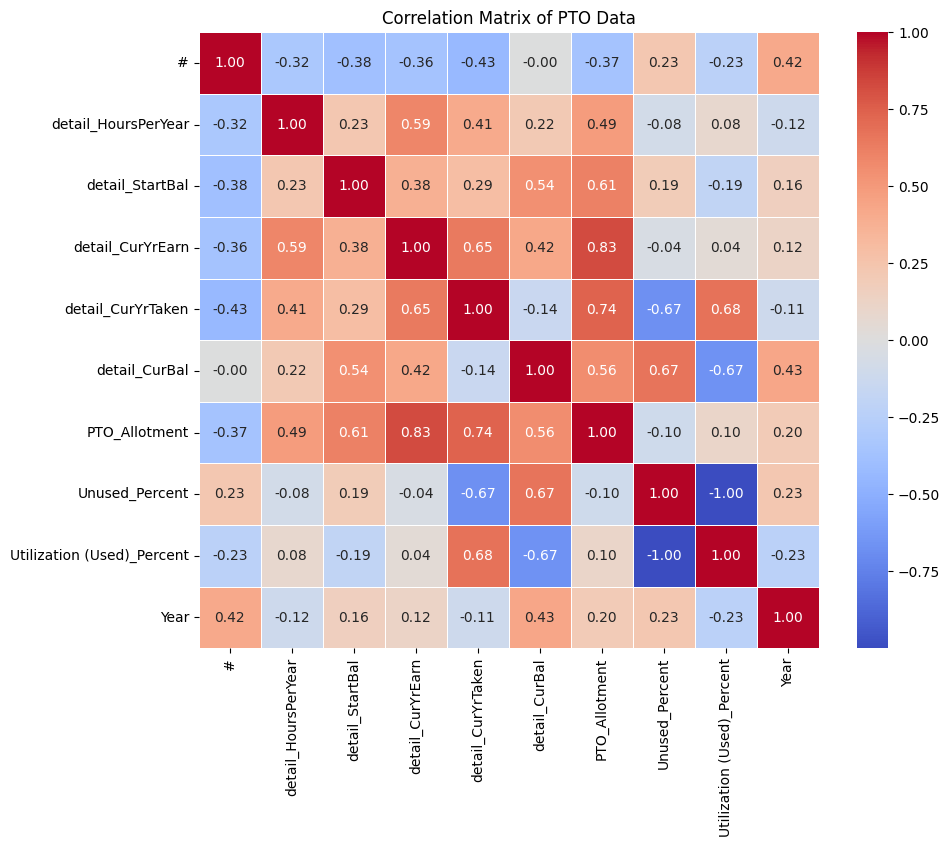

,detail_CurYrTaken
detail_CurYrTaken,1.000000
PTO_Allotment,0.742080
Utilization (Used)_Percent,0.675108
detail_CurYrEarn,0.646142
detail_HoursPerYear,0.406853
detail_StartBal,0.292968
Year,-0.114705
detail_CurBal,-0.141766
#,-0.433706
Unused_Percent,-0.674985


In [5]:
# Filter out non-numeric columns before computing the correlation matrix
numeric_data = pto_data.select_dtypes(include=['float64', 'int64'])

# Compute and plot the correlation matrix for only numeric data
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of PTO Data')
plt.show()

# Display correlations with 'detail_CurYrTaken' (PTO taken)
correlation_matrix['detail_CurYrTaken'].sort_values(ascending=False)



### **Train-Test Split**

In [3]:
# Select features and target variable
features = ['PTO_Allotment', 'Utilization (Used)_Percent', 'detail_CurYrEarn', 'detail_HoursPerYear']
target = 'detail_CurYrTaken'

# Split the data
X = pto_data[features]
y = pto_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


##  **Train these 2 models for the best performance**

1. Linear Regression Model
2. Random Forest Regression Model


In [4]:
# Train a linear regression model and evaluate its performance.

# Check for any missing values in the training and testing data
print(X_train.isna().sum())
print(X_test.isna().sum())



# Fill NaN values with the mean of each feature in both train and test sets
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())


# Drop rows with NaN values in both train and test sets
X_train = X_train.dropna()
X_test = X_test.dropna()
y_train = y_train[X_train.index]  # Align target variable with the cleaned feature set
y_test = y_test[X_test.index]


PTO_Allotment                  0
Utilization (Used)_Percent    22
detail_CurYrEarn               0
detail_HoursPerYear            0
dtype: int64
PTO_Allotment                 0
Utilization (Used)_Percent    6
detail_CurYrEarn              0
detail_HoursPerYear           0
dtype: int64


In [5]:

# Train the Linear Regression model again
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions
y_pred = linear_model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression - MSE: {mse}, MAE: {mae}, R2: {r2}")


Linear Regression - MSE: 658.4488416040944, MAE: 18.969136559210504, R2: 0.8602783609458506


##  **Random Forest Regression Model**
Train and evaluate a Random Forest Regressor.

In [6]:
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_rf_pred = rf_model.predict(X_test)

# Evaluate performance
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_mae = mean_absolute_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)

print(f"Random Forest - MSE: {rf_mse}, MAE: {rf_mae}, R2: {rf_r2}")


Random Forest - MSE: 14.196599776160236, MAE: 2.5242466112748323, R2: 0.9969875075110034


##  **Visualize Actual vs. Predicted PTO Usage**

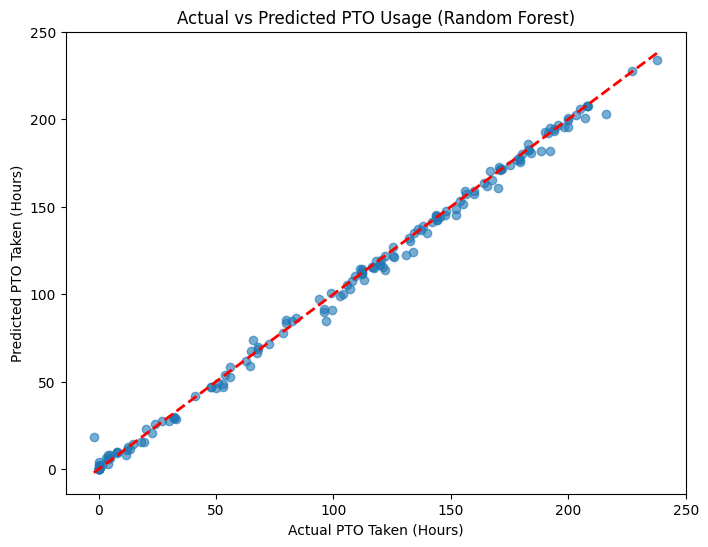

In [7]:
# Compare actual and predicted values.
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_rf_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual PTO Taken (Hours)')
plt.ylabel('Predicted PTO Taken (Hours)')
plt.title('Actual vs Predicted PTO Usage (Random Forest)')
plt.show()


# **Simulate PTO Usage for 2025 Scenarios**
Run different scenarios for PTO predictions.

In [8]:
# Define scenarios
scenarios = {
    "Base Case": {'PTO_Allotment': X_train['PTO_Allotment'].mean(),
                  'Utilization (Used)_Percent': X_train['Utilization (Used)_Percent'].mean()},
    "Scenario 1: +10% Allotment": {'PTO_Allotment': X_train['PTO_Allotment'].mean() * 1.1,
                                   'Utilization (Used)_Percent': X_train['Utilization (Used)_Percent'].mean()},
    "Scenario 2: -10% Allotment": {'PTO_Allotment': X_train['PTO_Allotment'].mean() * 0.9,
                                   'Utilization (Used)_Percent': X_train['Utilization (Used)_Percent'].mean()},
    "Scenario 3: +10% Utilization": {'PTO_Allotment': X_train['PTO_Allotment'].mean(),
                                     'Utilization (Used)_Percent': X_train['Utilization (Used)_Percent'].mean() * 1.1},
    "Scenario 4: -10% Utilization": {'PTO_Allotment': X_train['PTO_Allotment'].mean(),
                                     'Utilization (Used)_Percent': X_train['Utilization (Used)_Percent'].mean() * 0.9}
}

# Create DataFrame and predict
scenario_df = pd.DataFrame(scenarios).T
scenario_df['detail_CurYrEarn'] = X_train['detail_CurYrEarn'].mean()
scenario_df['detail_HoursPerYear'] = X_train['detail_HoursPerYear'].mean()
scenario_df['Predicted_PTO_Usage'] = rf_model.predict(scenario_df)

# Display results
scenario_df[['PTO_Allotment', 'Utilization (Used)_Percent', 'Predicted_PTO_Usage']]


,PTO_Allotment,Utilization (Used)_Percent,Predicted_PTO_Usage
Base Case,162.250736,0.648492,112.5750
Scenario 1: +10% Allotment,178.475810,0.648492,119.3600
Scenario 2: -10% Allotment,146.025663,0.648492,93.6000
Scenario 3: +10% Utilization,162.250736,0.713341,117.2450
Scenario 4: -10% Utilization,162.250736,0.583643,94.8925


## **Export Results to CSV**
Save the scenario results.

In [10]:
from google.colab import files

# Export the DataFrame to a CSV
scenario_df.to_csv('PTO_Simulation_Results.csv')

# Download the CSV
files.download('PTO_Simulation_Results.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Breaking Down PTO Predictions at the Employee Level**

To predict PTO usage at the granular level for each employee in 2025, here’s a step-by-step breakdown of how we can proceed following best practices:

Approach:
1. Historical Trends Detection:

   - Use 2024 data as a baseline since it reflects the most recent trends.
   - Use employee-level features (e.g., PTO_Allotment, Utilization (Used)_Percent, etc.) to capture patterns.

2. Train the Model with Employee-Level Data:

   - Use all past data up to 2024 for training (ensuring the most recent trends are captured).
  - Predict 2025 PTO usage at the employee level.

3. Side-by-Side Comparison for 2024 vs. 2025:

  - Predict 2025 PTO usage for each employee using the Random Forest model.
  - Compare predictions for 2025 against the actual PTO usage in 2024.


###  **Step 1: Filter and Prepare Data for 2024**

In [11]:
# Filter the dataset to use only 2024 as the baseline for predictions
pto_2024 = pto_data[pto_data['Year'] == 2024]

# Ensure relevant columns for training the model
features = ['PTO_Allotment', 'Utilization (Used)_Percent',
            'detail_CurYrEarn', 'detail_HoursPerYear']

# Prepare training data (for 2024) and target (PTO taken in 2024)
X_2024 = pto_2024[features]
y_2024 = pto_2024['detail_CurYrTaken']

# Check the prepared data
X_2024.head(), y_2024.head()


(     PTO_Allotment  Utilization (Used)_Percent  detail_CurYrEarn  \
 570          280.0                        0.31        200.000000   
 571          280.0                        0.26        200.000000   
 572            0.0                         NaN        147.767106   
 573          213.5                        0.40        200.000000   
 574          248.0                        0.48        200.000000   
 
      detail_HoursPerYear  
 570           200.000000  
 571           200.000000  
 572           172.064628  
 573           200.000000  
 574           200.000000  ,
 570     86.0
 571     72.0
 572      0.0
 573     86.0
 574    120.0
 Name: detail_CurYrTaken, dtype: float64)

### **Step 2: Train the Model with 2024 Data**

In [12]:
# Train the Random Forest model on 2024 data
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_2024, y_2024)


RandomForestRegressor(random_state=42)

### **Step 3: Predict PTO Usage for 2025 at the Employee Level**

In [13]:
# Create a copy of the 2024 data to use for 2025 predictions
pto_2025 = pto_2024.copy()
pto_2025['Year'] = 2025  # Update year to 2025

# Predict PTO usage for 2025 using the trained model
pto_2025['Predicted_PTO_Usage_2025'] = rf_model.predict(pto_2025[features])

# Compare side-by-side: Actual 2024 vs. Predicted 2025 PTO usage
comparison_df = pto_2025[['Employee', 'PTO_Allotment',
                          'detail_CurYrTaken', 'Predicted_PTO_Usage_2025']]
comparison_df = comparison_df.rename(columns={
    'detail_CurYrTaken': 'Actual_PTO_Usage_2024'
})

# Display the comparison
comparison_df.head()


,Employee,PTO_Allotment,Actual_PTO_Usage_2024,Predicted_PTO_Usage_2025
570,Kevin Hickey,280.0,86.0,84.065000
571,William Straub,280.0,72.0,71.725625
572,John Egan,0.0,0.0,0.000000
573,Anne Vitale,213.5,86.0,87.137500
574,Eric Swisher,248.0,120.0,119.582500


### **Step 4: Evaluate Model and Provide Insights**

In [14]:
# Calculate the error metrics between 2024 actual and 2025 predicted usage
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(comparison_df['Actual_PTO_Usage_2024'],
                         comparison_df['Predicted_PTO_Usage_2025'])
mae = mean_absolute_error(comparison_df['Actual_PTO_Usage_2024'],
                          comparison_df['Predicted_PTO_Usage_2025'])
r2 = r2_score(comparison_df['Actual_PTO_Usage_2024'],
              comparison_df['Predicted_PTO_Usage_2025'])

print(f"MSE: {mse}, MAE: {mae}, R2: {r2}")


MSE: 5.9001901475012435, MAE: 1.521435582533409, R2: 0.9977017662029434


### **Step 5: Export Employee-Level Predictions for 2025**

In [15]:
# Export the comparison results to a CSV file
comparison_df.to_csv('Employee_PTO_Predictions_2025.csv', index=False)
from google.colab import files
files.download('Employee_PTO_Predictions_2025.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


## **ALTERNATIVE ANALYSIS** :  


1. Use multi-year historical data (2020–2024) to train the model.

2. Predict PTO usage for 2025 for each employee, based on detail_CurYrTaken (Current PTO Taken) values from previous years.

3. Compare historical PTO usage (from 2020–2024) with 2025 predictions.

4. Export the results into a CSV file so management can easily review employee-level trends and predictions.



###  **Step 1 : Data Preparation for Multi-Year Modeling (2020–2024)**

In [16]:
# Filter data to include only 2020–2024
historical_data = pto_data[pto_data['Year'].between(2020, 2024)]

# Select features and target variable for modeling
features = ['PTO_Allotment', 'Utilization (Used)_Percent',
            'detail_CurYrEarn', 'detail_HoursPerYear']
target = 'detail_CurYrTaken'  # PTO taken in each year

# Ensure no NaN values in the selected features/target
historical_data[features] = historical_data[features].fillna(historical_data[features].mean())
historical_data[target] = historical_data[target].fillna(0)

# Train-Test Split: Use all data from 2020–2024 for training
X = historical_data[features]
y = historical_data[target]

# Train-test split (keeping 80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### **Step 2: Train the Random Forest Model**

In [17]:
# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_test_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Model Performance on Test Data - MSE: {mse}, MAE: {mae}, R2: {r2}")


Model Performance on Test Data - MSE: 14.196599776160236, MAE: 2.5242466112748323, R2: 0.9969875075110034


### **Step 3 : Predict PTO Usage for 2025 and Compare with Historical Data**

In [18]:
# Create a DataFrame for 2025 predictions based on the most recent data from 2024
pto_2025 = pto_data[pto_data['Year'] == 2024].copy()
pto_2025['Year'] = 2025  # Update the year

# Predict 2025 PTO usage for each employee
pto_2025['Predicted_PTO_Usage_2025'] = rf_model.predict(pto_2025[features])

# Merge 2025 predictions with historical data to compare side-by-side
comparison_df = pd.merge(
    historical_data[['Employee', 'Year', 'detail_CurYrTaken']],
    pto_2025[['Employee', 'Predicted_PTO_Usage_2025']],
    on='Employee',
    how='left'
)

# Pivot the table to show historical PTO usage per year alongside the 2025 prediction
comparison_df = comparison_df.pivot(index='Employee', columns='Year', values='detail_CurYrTaken').reset_index()
comparison_df = comparison_df.merge(pto_2025[['Employee', 'Predicted_PTO_Usage_2025']], on='Employee', how='left')

# Display the comparison DataFrame
comparison_df.head()


,Employee,2020,2021,2022,2023,2024,Predicted_PTO_Usage_2025
0,AJ Golding,NaN,NaN,103.0,101.50,52.25,53.4975
1,AJ Scheftner,NaN,NaN,NaN,NaN,129.50,130.0050
2,Aaron Tainatongo,NaN,NaN,NaN,NaN,200.50,199.6150
3,Abigail Frank,NaN,NaN,20.0,145.75,112.00,112.6050
4,Adam Czaplinski,NaN,NaN,110.0,151.00,45.50,43.3025


### **Step 5: Export the Predictions for Download**

In [19]:
# Export the comparison DataFrame to a CSV file
comparison_df.to_csv('Employee_PTO_Predictions_2025.csv', index=False)

# Provide a download link
from google.colab import files
files.download('Employee_PTO_Predictions_2025.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### **Q1: What is the overall PTO usage across different Business Units (BU)?**

In [20]:
# Group by Business Unit (BU) to calculate total PTO usage
bu_usage = pto_data.groupby('BU')['detail_CurYrTaken'].sum().reset_index()
bu_usage = bu_usage.rename(columns={'detail_CurYrTaken': 'Total_PTO_Usage'})

# Display the results
print(bu_usage)


      BU  Total_PTO_Usage
0    AIR           461.00
1    AQM          4394.50
2    ATL         10383.35
3    BOS           325.25
4    CAL           353.25
5    CMS          6056.00
6   CORP         15552.75
7    DSP          7302.00
8    EHS           462.50
9    ESG           542.00
10   HOU          3592.75
11   KTY          5636.50
12   LOU           452.00
13   PHI             4.00
14   PHL         19147.00
15   RAL          5234.75
16   WAS          2483.00
17   WDC          4398.00


#### **Q2: Is the 100% utilization assumption valid? Does it allow for balance between PTO and overhead?**

In [21]:
# Calculate PTO utilization percentage per employee
pto_data['PTO_Utilization_Percent'] = (
    pto_data['detail_CurYrTaken'] / pto_data['PTO_Allotment']
) * 100

# Summary statistics of utilization percentages
utilization_summary = pto_data['PTO_Utilization_Percent'].describe()

print(utilization_summary)


count    788.000000
mean            inf
std             NaN
min        0.000000
25%       47.058824
50%       71.654229
75%       86.269531
max             inf
Name: PTO_Utilization_Percent, dtype: float64


### **Q3: What should the PTO projection be going into 2025? Forecasting 2025 PTO Usage**

Using Random Forest Regression, we forecast PTO usage for 2025 based on historical data. This provides management with a reliable projection to plan resources and manage staffing for the upcoming year. Refer run files on local drive



In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Filter historical data (2020–2024)
historical_data = pto_data[pto_data['Year'].between(2020, 2024)]

# Select relevant features and target variable
features = ['PTO_Allotment', 'detail_CurYrEarn', 'detail_CurBal', 'detail_HoursPerYear']
X = historical_data[features]
y = historical_data['detail_CurYrTaken']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict PTO usage for 2025
pto_2025 = historical_data[historical_data['Year'] == 2024][features]
pto_2025['Predicted_PTO_Usage_2025'] = rf_model.predict(pto_2025)

# Display predictions
print(pto_2025[['Predicted_PTO_Usage_2025']])


     Predicted_PTO_Usage_2025
570                   83.9125
571                   70.9175
572                    0.0000
573                   87.8450
574                  119.2525
..                        ...
824                   18.5925
825                   31.3725
826                   11.8475
827                   17.9625
828                    2.4675

[253 rows x 1 columns]


### **Q4: Is the rate at which PTO is being used increasing?**

In [23]:
#   By Person:

# Group by Employee and Year to calculate annual PTO usage
employee_usage = pto_data.groupby(['Employee', 'Year'])['detail_CurYrTaken'].sum().reset_index()
print(employee_usage)


                   Employee  Year  detail_CurYrTaken
0                AJ Golding  2022             103.00
1                AJ Golding  2023             101.50
2                AJ Golding  2024              52.25
3              AJ Scheftner  2024             129.50
4          Aaron Tainatongo  2024             200.50
..                      ...   ...                ...
810  Yatziri Enriquez-Lopez  2024               0.00
811               Zach Stay  2021              11.75
812               Zach Stay  2022             131.00
813               Zach Stay  2023             149.75
814               Zach Stay  2024             121.00

[815 rows x 3 columns]


### **Q4: Is the rate at which PTO is being used increasing?**

By Business Unit (BU):

In [24]:
# Group by BU and Year to calculate annual PTO usage per BU
bu_trend = pto_data.groupby(['BU', 'Year'])['detail_CurYrTaken'].sum().reset_index()
print(bu_trend)


     BU  Year  detail_CurYrTaken
0   AIR  2022             132.00
1   AIR  2023             201.00
2   AIR  2024             128.00
3   AQM  2020             529.00
4   AQM  2021             748.00
..  ...   ...                ...
65  WDC  2020             714.75
66  WDC  2021             792.50
67  WDC  2022             942.50
68  WDC  2023            1123.75
69  WDC  2024             824.50

[70 rows x 3 columns]


### Q5: **How does historical PTO usage predict future usage by employee?**

In [ ]:
#   By Person:

# Group by Employee and Year to calculate annual PTO usage
employee_usage = pto_data.groupby(['Employee', 'Year'])['detail_CurYrTaken'].sum().reset_index()
print(employee_usage)


                   Employee  Year  detail_CurYrTaken
0                AJ Golding  2022             103.00
1                AJ Golding  2023             101.50
2                AJ Golding  2024              52.25
3              AJ Scheftner  2024             129.50
4          Aaron Tainatongo  2024             200.50
..                      ...   ...                ...
810  Yatziri Enriquez-Lopez  2024               0.00
811               Zach Stay  2021              11.75
812               Zach Stay  2022             131.00
813               Zach Stay  2023             149.75
814               Zach Stay  2024             121.00

[815 rows x 3 columns]


In [29]:
# Calculate total PTO usage for CORP and other units
corp_usage = pto_data[pto_data['BU'] == 'CORP']['detail_CurYrTaken'].sum()
billable_usage = pto_data[pto_data['BU'] != 'CORP'].groupby('BU')['detail_CurYrTaken'].sum()

print(f"Total PTO usage for CORP: {corp_usage}")
print("PTO usage for billable units:\n", billable_usage)



Total PTO usage for CORP: 15552.75
PTO usage for billable units:
 BU
AIR      461.00
AQM     4394.50
ATL    10383.35
BOS      325.25
CAL      353.25
CMS     6056.00
DSP     7302.00
EHS      462.50
ESG      542.00
HOU     3592.75
KTY     5636.50
LOU      452.00
PHI        4.00
PHL    19147.00
RAL     5234.75
WAS     2483.00
WDC     4398.00
Name: detail_CurYrTaken, dtype: float64


In [30]:
import pandas as pd

# Load the dataset
pto_data = pd.read_csv('PTO_Data_Machine learning_v2.csv')

# Pivot table to track PTO usage by Employee and Year
employee_trends = pto_data.pivot_table(
    index='Employee', columns='Year', values='detail_CurYrTaken', aggfunc='sum'
).reset_index()

# Calculate year-over-year change (YoY Change) for each employee
employee_trends['YoY_Change_2021'] = employee_trends[2021] - employee_trends[2020]
employee_trends['YoY_Change_2022'] = employee_trends[2022] - employee_trends[2021]
employee_trends['YoY_Change_2023'] = employee_trends[2023] - employee_trends[2022]
employee_trends['YoY_Change_2024'] = employee_trends[2024] - employee_trends[2023]

# Show the pivot table with YoY changes
print(employee_trends)


Year                Employee   2020    2021   2022    2023    2024  \
0                 AJ Golding    NaN     NaN  103.0  101.50   52.25   
1               AJ Scheftner    NaN     NaN    NaN     NaN  129.50   
2           Aaron Tainatongo    NaN     NaN    NaN     NaN  200.50   
3              Abigail Frank    NaN     NaN   20.0  145.75  112.00   
4            Adam Czaplinski    NaN     NaN  110.0  151.00   45.50   
..                       ...    ...     ...    ...     ...     ...   
259           William Straub  120.0  184.00  136.0  100.50   72.00   
260             Xyan Aguilar    NaN     NaN    NaN   24.00   57.00   
261               Yash Patel    NaN     NaN    NaN     NaN    0.00   
262   Yatziri Enriquez-Lopez    NaN     NaN    NaN     NaN    0.00   
263                Zach Stay    NaN   11.75  131.0  149.75  121.00   

Year  YoY_Change_2021  YoY_Change_2022  YoY_Change_2023  YoY_Change_2024  
0                 NaN              NaN            -1.50           -49.25  
1        

In [31]:
employee_trends.to_csv('Employee_PTO_Trends.csv', index=False)
